DXG

In [1]:
import pandas as pd
import numpy as np
# from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 2. Đọc file csv và gắng index với giá Close
dxg = pd.read_csv('../../DATASET/DXG.csv')
qcg = pd.read_csv('../../DATASET/QCG.csv')
vhm = pd.read_csv('../../DATASET/VHM.csv')

def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
# Áp dụng hàm cho toàn bộ DataFrame
dxg = dxg['Close'].apply(remove_commas_and_convert)
qcg = qcg['Close'].apply(remove_commas_and_convert)
vhm = vhm['Close'].apply(remove_commas_and_convert)

dxg1=dxg.reset_index()['Close']
qcg1=qcg.reset_index()['Close']
vhm1=vhm.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [4]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.9 * len(dxg1))
dxg_test_size = len(dxg1) - dxg_train_size 
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]



#QCG
qcg_train_size = int(0.9 * len(qcg1))
qcg_test_size = len(qcg1) - qcg_train_size 
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]


#VHM
vhm_train_size = int(0.9 * len(vhm1))
vhm_test_size = len(vhm1) - vhm_train_size 
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]


In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
# dxg_X_val, dxg_yval = create_dataset(dxg_val_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
# qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
# vhm_X_val, vhm_yval = create_dataset(vhm_val_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [7]:
dxg_X_train.shape
qcg_X_train.shape
vhm_X_train.shape

(1025, 100)

In [8]:
dxg_model = RandomForestRegressor()
dxg_model.fit(dxg_X_train, dxg_y_train)

qcg_model = RandomForestRegressor()
qcg_model.fit(qcg_X_train, qcg_y_train)

vhm_model = RandomForestRegressor()
vhm_model.fit(vhm_X_train, vhm_y_train)


RandomForestRegressor()

In [14]:
dxg_train_predict = dxg_model.predict(dxg_X_train)
dxg_y_pred = dxg_model.predict(dxg_X_test)


qcg_train_predict = qcg_model.predict(qcg_X_train)
qcg_y_pred = qcg_model.predict(qcg_X_test)


vhm_train_predict = vhm_model.predict(vhm_X_train)
vhm_y_pred = vhm_model.predict(vhm_X_test)



In [22]:
from sklearn.metrics import mean_squared_log_error


#DXG
actual=scaler.inverse_transform(dxg_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(dxg_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)

print('DXG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MSLE: {msle}\n")

# QCG
actual=scaler.inverse_transform(qcg_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(qcg_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)

print('QCG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MSLE: {msle}\n")

# VHM
actual=scaler.inverse_transform(vhm_test_data)
actual= actual[101:]
forecast = scaler.inverse_transform(vhm_y_pred.reshape(1, -1).tolist())
forecast = np.array(forecast).reshape(-1, 1)

rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)

print('VHM')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MSLE: {msle}\n")



DXG
RMSE: 813.8228827019348
MAPE:  0.014648002238543128
MSLE: 0.00025828876721710004

QCG
RMSE: 838.2945883696723
MAPE:  0.014262643161958017
MSLE: 0.0003646733975285437

VHM
RMSE: 1620.2567641519017
MAPE:  0.018106340935470158
MSLE: 0.0005529991926942748



In [16]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#DXG
x_input = dxg_test_data[-time_step:].reshape(1, -1)
new = dxg_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
dxg_lst_output = []
n_steps = 100
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]

        dxg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        dxg_lst_output.extend(yhat.tolist())
        i += 1

dxg_lst_output = np.array(dxg_lst_output).reshape(-1, 1)



In [17]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#QCG
x_input = qcg_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
qcg_lst_output = []
n_steps = 100
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())

        temp_input = temp_input[1:]
        qcg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        qcg_lst_output.extend(yhat.tolist())
        i += 1

qcg_lst_output = np.array(qcg_lst_output).reshape(-1, 1)

In [18]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#VHM
x_input = vhm_test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
vhm_lst_output = []
n_steps = 100
i = 0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        vhm_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        vhm_lst_output.extend(yhat.tolist())
        i += 1

vhm_lst_output = np.array(vhm_lst_output).reshape(-1, 1)

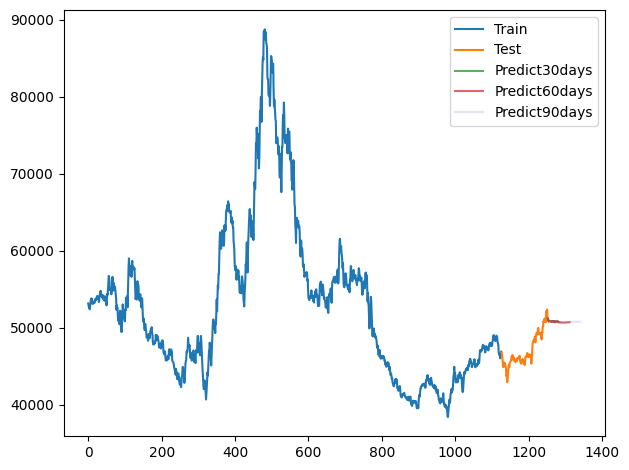

In [19]:
# 14.Vẽ hình
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#DXG
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
plt.plot(scaler.inverse_transform(dxg_train_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))
dxg_predict_data_30= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 30,step=1)
dxg_predict_data_60= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 60,step=1)
dxg_predict_data_90= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 90,step=1)
plt.plot(dxg_predict_data_30,scaler.inverse_transform(dxg_lst_output[:30]), alpha=0.8)
plt.plot(dxg_predict_data_60,scaler.inverse_transform(dxg_lst_output[:60]), alpha=0.7)
plt.plot(dxg_predict_data_90,scaler.inverse_transform(dxg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

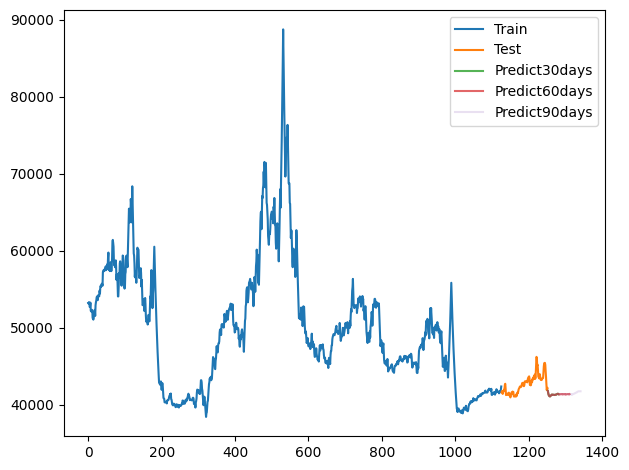

In [20]:
#qcg
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
plt.plot(scaler.inverse_transform(qcg_train_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))
qcg_predict_data_30= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 30,step=1)
qcg_predict_data_60= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 60,step=1)
qcg_predict_data_90= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 90,step=1)
plt.plot(qcg_predict_data_30,scaler.inverse_transform(qcg_lst_output[:30]), alpha=0.8)
plt.plot(qcg_predict_data_60,scaler.inverse_transform(qcg_lst_output[:60]), alpha=0.7)
plt.plot(qcg_predict_data_90,scaler.inverse_transform(qcg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

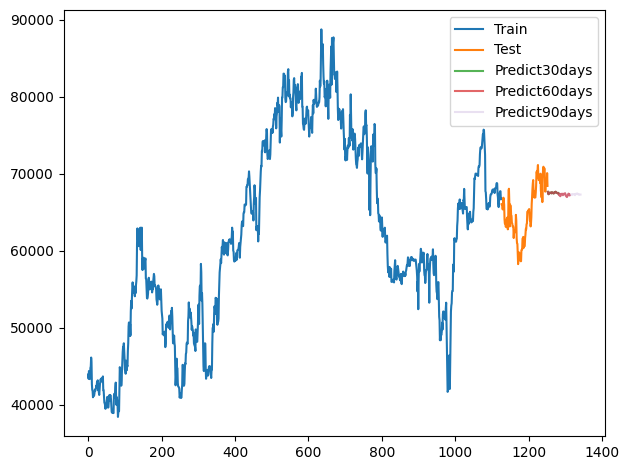

In [21]:
#DXG
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
plt.plot(scaler.inverse_transform(vhm_train_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))
vhm_predict_data_30= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 30,step=1)
vhm_predict_data_60= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 60,step=1)
vhm_predict_data_90= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 90,step=1)
plt.plot(vhm_predict_data_30,scaler.inverse_transform(vhm_lst_output[:30]), alpha=0.8)
plt.plot(vhm_predict_data_60,scaler.inverse_transform(vhm_lst_output[:60]), alpha=0.7)
plt.plot(vhm_predict_data_90,scaler.inverse_transform(vhm_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()